<a href="https://colab.research.google.com/github/jason2mo/disco-diffusion/blob/main/AI_Animating_Beginner_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1) Download all dependencies for A.I. Animator**


**Uses Vq+C to generate the frames and a series of animation techniques on top of it to zoom, rotate, and shift by x, y pixels**

**Video coming soon!**




In [1]:
!nvidia-smi

Wed Jun 22 06:22:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# @title **Licensed under the MIT License**

# Copyright (c) 2021 Katherine Crowson

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

working_dir = '/content'

In [3]:
#@markdown #**Check GPU type**
#@markdown ### Factory reset runtime if you don't have the desired GPU.

#@markdown ---




#@markdown V100 = Excellent (*Available only for Colab Pro users*)

#@markdown P100 = Very Good (*Available only for Colab Pro users*)

#@markdown T4 = Good (*Available only for Colab Pro users*)

#@markdown K80 = (*Untested*)

#@markdown P4 = (*Not Recommended*) 

#@markdown ---

!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-38bab34c-8b74-32e4-db41-7ac52655614b)


In [4]:
# @title #**Library installation**
# @markdown This cell will take a while because you have to download multiple libraries

print("Downloading CLIP...")
!git clone https://github.com/openai/CLIP                 &> /dev/null
 
print("Downloading Python AI libraries...")
!git clone https://github.com/CompVis/taming-transformers &> /dev/null
!pip install ftfy regex tqdm omegaconf pytorch-lightning  &> /dev/null
!pip install kornia                                       &> /dev/null
!pip install einops                                       &> /dev/null
 
print("Installing libraries for handling metadata...")
!pip install stegano                                      &> /dev/null
!apt install exempi                                       &> /dev/null
!pip install python-xmp-toolkit                           &> /dev/null
!pip install imgtag                                       &> /dev/null
!pip install pillow==7.1.2                                &> /dev/null
 
print("Installing Python video creation libraries...")
!pip install imageio-ffmpeg &> /dev/null
path = f'{working_dir}/steps'
!mkdir --parents {path}
print("Installation finished.")

Installing libraries for handling metadata...
Installing Python video creation libraries...
Installation finished.


In [5]:
#@title #**Selection of models to download**
#@markdown By default, the notebook downloads Model 16384 from ImageNet. There are others such as ImageNet 1024, COCO-Stuff, WikiArt 1024, WikiArt 16384, FacesHQ or S-FLCKR, which are not downloaded by default, since it would be in vain if you are not going to use them, so if you want to use them, simply select the models to download.

imagenet_1024 = False #@param {type:"boolean"}
imagenet_16384 = True #@param {type:"boolean"}
coco = False #@param {type:"boolean"}
faceshq = False #@param {type:"boolean"}
wikiart_16384 = False #@param {type:"boolean"}
sflckr = False #@param {type:"boolean"}

if imagenet_1024:
  !curl -L -o vqgan_imagenet_f16_1024.yaml -C - 'https://heibox.uni-heidelberg.de/d/8088892a516d4e3baf92/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' #ImageNet 1024
  !curl -L -o vqgan_imagenet_f16_1024.ckpt -C - 'https://heibox.uni-heidelberg.de/d/8088892a516d4e3baf92/files/?p=%2Fckpts%2Flast.ckpt&dl=1'  #ImageNet 1024
if imagenet_16384:
  !curl -L -o vqgan_imagenet_f16_16384.yaml -C - 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' #ImageNet 16384
  !curl -L -o vqgan_imagenet_f16_16384.ckpt -C - 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fckpts%2Flast.ckpt&dl=1' #ImageNet 16384
if coco:
  !curl -L -o coco.yaml -C - 'https://dl.nmkd.de/ai/clip/coco/coco.yaml' #COCO
  !curl -L -o coco.ckpt -C - 'https://dl.nmkd.de/ai/clip/coco/coco.ckpt' #COCO
if faceshq:
  !curl -L -o faceshq.yaml -C - 'https://drive.google.com/uc?export=download&id=1fHwGx_hnBtC8nsq7hesJvs-Klv-P0gzT' #FacesHQ
  !curl -L -o faceshq.ckpt -C - 'https://app.koofr.net/content/links/a04deec9-0c59-4673-8b37-3d696fe63a5d/files/get/last.ckpt?path=%2F2020-11-13T21-41-45_faceshq_transformer%2Fcheckpoints%2Flast.ckpt' #FacesHQ
if wikiart_16384:
  !curl -L -o wikiart_16384.yaml -C - 'http://eaidata.bmk.sh/data/Wikiart_16384/wikiart_f16_16384_8145600.yaml' #WikiArt 16384
  !curl -L -o wikiart_16384.ckpt -C - 'http://eaidata.bmk.sh/data/Wikiart_16384/wikiart_f16_16384_8145600.ckpt' #WikiArt 16384
if sflckr:
  !curl -L -o sflckr.yaml -C - 'https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fconfigs%2F2020-11-09T13-31-51-project.yaml&dl=1' #S-FLCKR
  !curl -L -o sflckr.ckpt -C - 'https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fcheckpoints%2Flast.ckpt&dl=1' #S-FLCKR

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   692  100   692    0     0   1079      0 --:--:-- --:--:-- --:--:--  1079
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  934M  100  934M    0     0  14.8M      0  0:01:02  0:01:02 --:--:-- 14.9M


In [6]:
# @title #**Loading of libraries and definitions**
 
import argparse
import math
from pathlib import Path
import sys
import os
import cv2
import pandas as pd
import numpy as np
import subprocess
 
sys.path.append('./taming-transformers')

# Some models include transformers, others need explicit pip install
try:
    import transformers
except Exception:
    !pip install transformers
    import transformers

from IPython import display
from base64 import b64encode
from omegaconf import OmegaConf
from PIL import Image
from taming.models import cond_transformer, vqgan
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm
 
from CLIP import clip
import kornia.augmentation as K
import numpy as np
import imageio
from PIL import ImageFile, Image
from imgtag import ImgTag    # metadata 
from libxmp import *         # metadata
import libxmp                # metadata
from stegano import lsb
import json
ImageFile.LOAD_TRUNCATED_IMAGES = True
 
def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))
 
 
def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()
 
 
def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]
 
 
def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size
 
    input = input.view([n * c, 1, h, w])
 
    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])
 
    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])
 
    input = input.view([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)
 
 
class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward
 
    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)
 
 
replace_grad = ReplaceGrad.apply
 
 
class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)
 
    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None
 
 
clamp_with_grad = ClampWithGrad.apply
 
 
def vector_quantize(x, codebook):
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
    return replace_grad(x_q, x)
 
 
class Prompt(nn.Module):
    def __init__(self, embed, weight=1., stop=float('-inf')):
        super().__init__()
        self.register_buffer('embed', embed)
        self.register_buffer('weight', torch.as_tensor(weight))
        self.register_buffer('stop', torch.as_tensor(stop))
 
    def forward(self, input):
        input_normed = F.normalize(input.unsqueeze(1), dim=2)
        embed_normed = F.normalize(self.embed.unsqueeze(0), dim=2)
        dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
        dists = dists * self.weight.sign()
        return self.weight.abs() * replace_grad(dists, torch.maximum(dists, self.stop)).mean()
 
 
def parse_prompt(prompt):
    vals = prompt.rsplit(':', 2)
    vals = vals + ['', '1', '-inf'][len(vals):]
    return vals[0], float(vals[1]), float(vals[2])
 
 
class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow
        self.augs = nn.Sequential(
            K.RandomHorizontalFlip(p=0.5),
            # K.RandomSolarize(0.01, 0.01, p=0.7),
            K.RandomSharpness(0.3,p=0.4),
            K.RandomAffine(degrees=30, translate=0.1, p=0.8, padding_mode='border'),
            K.RandomPerspective(0.2,p=0.4),
            K.ColorJitter(hue=0.01, saturation=0.01, p=0.7))
        self.noise_fac = 0.1
 
 
    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))
        batch = self.augs(torch.cat(cutouts, dim=0))
        if self.noise_fac:
            facs = batch.new_empty([self.cutn, 1, 1, 1]).uniform_(0, self.noise_fac)
            batch = batch + facs * torch.randn_like(batch)
        return batch
 
 
def load_vqgan_model(config_path, checkpoint_path):
    config = OmegaConf.load(config_path)
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model
 
 
def resize_image(image, out_size):
    ratio = image.size[0] / image.size[1]
    area = min(image.size[0] * image.size[1], out_size[0] * out_size[1])
    size = round((area * ratio)**0.5), round((area / ratio)**0.5)
    return image.resize(size, Image.LANCZOS)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.1 MB/s 
     |████████████████████████████████| 101 kB 12.2 MB/s 
     |████████████████████████████████| 6.6 MB 47.9 MB/s 


#**2) Setting Up the A.I. Animator**



Tik tok resolution: 340px by 570px

Nice Square resolution: 500px by 500px or 400px by 400px

In [7]:
#@title **Parameters for Model, 12 frames=1 second**

width =  512#@param {type:"number"}
height =  512#@param {type:"number"}
model = "vqgan_imagenet_f16_16384"
interval =  1
initial_image = ""
target_images = ""
seed = -1
max_frames = 300#@param {type:"number"}


In [8]:
#@title **Parameters for Animating**
text_prompts = "0:(fantasy world matte painting splashes of colors in unreal engine: 1)" #@param {type:"string"}
key_frames = True
angle = "0: (0)"#@param {type:"string"}
zoom = "0:(0.95)"#@param {type:"string"}
translation_x = "0:(0)"#@param {type:"string"}
translation_y = "0:(5)"#@param {type:"string"}
iterations_per_frame = "0: (10)"
save_all_iterations = False
if initial_image != "":
    print(
        "WARNING: You have specified an initial image. Note that the image resolution "
        "will be inherited from this image, not whatever width and height you specified. "
        "If the initial image resolution is too high, this can result in out of memory errors."
    )
elif width * height > 160000:
    print(
        "WARNING: The width and height you have specified may be too high, in which case "
        "you will encounter out of memory errors either at the image generation stage or the "
        "video synthesis stage. If so, try reducing the resolution"
    )
model_names={
    "vqgan_imagenet_f16_16384": 'ImageNet 16384',
    "vqgan_imagenet_f16_1024":"ImageNet 1024", 
    "wikiart_1024":"WikiArt 1024",
    "wikiart_16384":"WikiArt 16384",
    "coco":"COCO-Stuff",
    "faceshq":"FacesHQ",
    "sflckr":"S-FLCKR"
}
model_name = model_names[model]

if seed == -1:
    seed = None

def parse_key_frames(string, prompt_parser=None):
    import re
    pattern = r'((?P<frame>[0-9]+):[\s]*[\(](?P<param>[\S\s]*?)[\)])'
    frames = dict()
    for match_object in re.finditer(pattern, string):
        frame = int(match_object.groupdict()['frame'])
        param = match_object.groupdict()['param']
        if prompt_parser:
            frames[frame] = prompt_parser(param)
        else:
            frames[frame] = param

    if frames == {} and len(string) != 0:
        raise RuntimeError('Key Frame string not correctly formatted')
    return frames

def get_inbetweens(key_frames, integer=False):
    key_frame_series = pd.Series([np.nan for a in range(max_frames)])
    for i, value in key_frames.items():
        key_frame_series[i] = value
    key_frame_series = key_frame_series.astype(float)
    key_frame_series = key_frame_series.interpolate(limit_direction='both')
    if integer:
        return key_frame_series.astype(int)
    return key_frame_series

def split_key_frame_text_prompts(frames):
    prompt_dict = dict()
    for i, parameters in frames.items():
        prompts = parameters.split('|')
        for prompt in prompts:
            string, value = prompt.split(':')
            string = string.strip()
            value = float(value.strip())
            if string in prompt_dict:
                prompt_dict[string][i] = value
            else:
                prompt_dict[string] = {i: value}
    prompt_series_dict = dict()
    for prompt, values in prompt_dict.items():
        value_string = (
            ', '.join([f'{value}: ({values[value]})' for value in values])
        )
        prompt_series = get_inbetweens(parse_key_frames(value_string))
        prompt_series_dict[prompt] = prompt_series
    prompt_list = []
    for i in range(max_frames):
        prompt_list.append(
            ' | '.join(
                [f'{prompt}: {prompt_series_dict[prompt][i]}'
                 for prompt in prompt_series_dict]
            )
        )
    return prompt_list

if key_frames:
    try:
        text_prompts_series = split_key_frame_text_prompts(
            parse_key_frames(text_prompts)
        )
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `text_prompts` correctly for key frames.\n"
            "Attempting to interpret `text_prompts` as "
            f'"0: ({text_prompts}:1)"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        text_prompts = f"0: ({text_prompts}:1)"
        text_prompts_series = split_key_frame_text_prompts(
            parse_key_frames(text_prompts)
        )

    try:
        target_images_series = split_key_frame_text_prompts(
            parse_key_frames(target_images)
        )
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `target_images` correctly for key frames.\n"
            "Attempting to interpret `target_images` as "
            f'"0: ({target_images}:1)"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        target_images = f"0: ({target_images}:1)"
        target_images_series = split_key_frame_text_prompts(
            parse_key_frames(target_images)
        )

    try:
        angle_series = get_inbetweens(parse_key_frames(angle))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `angle` correctly for key frames.\n"
            "Attempting to interpret `angle` as "
            f'"0: ({angle})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        angle = f"0: ({angle})"
        angle_series = get_inbetweens(parse_key_frames(angle))

    try:
        zoom_series = get_inbetweens(parse_key_frames(zoom))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `zoom` correctly for key frames.\n"
            "Attempting to interpret `zoom` as "
            f'"0: ({zoom})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        zoom = f"0: ({zoom})"
        zoom_series = get_inbetweens(parse_key_frames(zoom))

    try:
        translation_x_series = get_inbetweens(parse_key_frames(translation_x))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `translation_x` correctly for key frames.\n"
            "Attempting to interpret `translation_x` as "
            f'"0: ({translation_x})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        translation_x = f"0: ({translation_x})"
        translation_x_series = get_inbetweens(parse_key_frames(translation_x))

    try:
        translation_y_series = get_inbetweens(parse_key_frames(translation_y))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `translation_y` correctly for key frames.\n"
            "Attempting to interpret `translation_y` as "
            f'"0: ({translation_y})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        translation_y = f"0: ({translation_y})"
        translation_y_series = get_inbetweens(parse_key_frames(translation_y))

    try:
        iterations_per_frame_series = get_inbetweens(
            parse_key_frames(iterations_per_frame), integer=True
        )
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `iterations_per_frame` correctly for key frames.\n"
            "Attempting to interpret `iterations_per_frame` as "
            f'"0: ({iterations_per_frame})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        iterations_per_frame = f"0: ({iterations_per_frame})"
        
        iterations_per_frame_series = get_inbetweens(
            parse_key_frames(iterations_per_frame), integer=True
        )
else:
    text_prompts = [phrase.strip() for phrase in text_prompts.split("|")]
    if text_prompts == ['']:
        text_prompts = []
    if target_images == "None" or not target_images:
        target_images = []
    else:
        target_images = target_images.split("|")
        target_images = [image.strip() for image in target_images]

    angle = float(angle)
    zoom = float(zoom)
    translation_x = float(translation_x)
    translation_y = float(translation_y)
    iterations_per_frame = int(iterations_per_frame)

args = argparse.Namespace(
    prompts=text_prompts,
    image_prompts=target_images,
    noise_prompt_seeds=[],
    noise_prompt_weights=[],
    size=[width, height],
    init_weight=0.,
    clip_model='ViT-B/32',
    vqgan_config=f'{model}.yaml',
    vqgan_checkpoint=f'{model}.ckpt',
    step_size=0.1,
    cutn=64,
    cut_pow=1.,
    display_freq=interval,
    seed=seed,
)

# 3) **Running the A.I. Animator**

You can stop whenever you want by pressing the stop button! 

Cleared Accounted PIDs for GPU 00000000:00:04.0.
All done.
Using device: cuda:0
Using seed: 5654669523669073585
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

8.19kB [00:00, 677kB/s]                    


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from vqgan_imagenet_f16_16384.ckpt


100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 125MiB/s]


text_prompts: ['fantasy world matte painting splashes of colors in unreal engine: 1.0']angle: 0.0 zoom: 0.95 translation_x: -0.0 translation_y: 5.0 iterations_per_frame: 10


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


i: 1, loss: 0.935382, losses: 0.935382


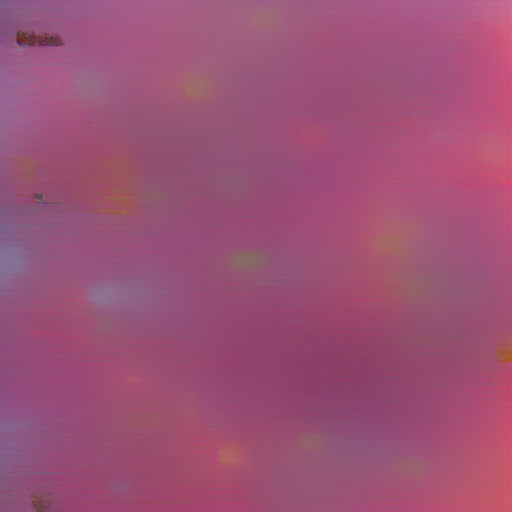

text_prompts: ['fantasy world matte painting splashes of colors in unreal engine: 1.0']angle: 0.0 zoom: 0.95 translation_x: -0.0 translation_y: 5.0 iterations_per_frame: 10


0it [00:00, ?it/s]

i: 2, loss: 0.88036, losses: 0.88036


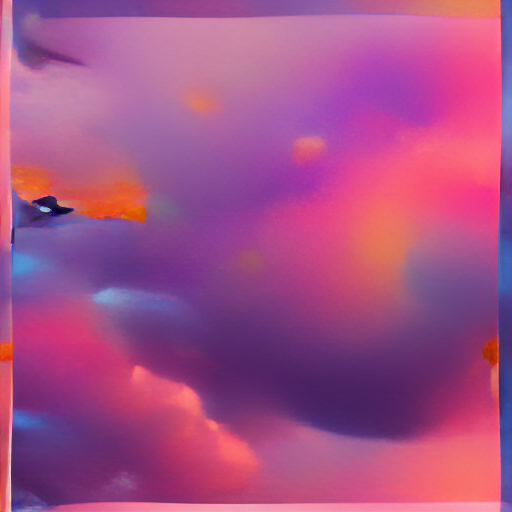

text_prompts: ['fantasy world matte painting splashes of colors in unreal engine: 1.0']angle: 0.0 zoom: 0.95 translation_x: -0.0 translation_y: 5.0 iterations_per_frame: 10


0it [00:00, ?it/s]

In [9]:
#@title #**Fire up the A.I**

path = f'{working_dir}/steps'
!rm -r {path}
!mkdir --parents {path}


if key_frames:
    filename = "video.mp4"
else:
    filename = f"{'_'.join(text_prompts).replace(' ', '')}.mp4"
filepath = f'{working_dir}/{filename}'


if key_frames:
    filename = "video.mp4"
else:
    filename = f"{'_'.join(text_prompts).replace(' ', '')}.mp4"
filepath = f'{working_dir}/{filename}'

# Delete memory from previous runs
!nvidia-smi -caa
for var in ['device', 'model', 'perceptor', 'z']:
  try:
      del globals()[var]
  except:
      pass

try:
    import gc
    gc.collect()
except:
    pass

try:
    torch.cuda.empty_cache()
except:
    pass

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if not key_frames:
    if text_prompts:
        print('Using text prompts:', text_prompts)
    if target_images:
        print('Using image prompts:', target_images)
if args.seed is None:
    seed = torch.seed()
else:
    seed = args.seed
torch.manual_seed(seed)
print('Using seed:', seed)
 
model = load_vqgan_model(args.vqgan_config, args.vqgan_checkpoint).to(device)
perceptor = clip.load(args.clip_model, jit=False)[0].eval().requires_grad_(False).to(device)
 
cut_size = perceptor.visual.input_resolution
e_dim = model.quantize.e_dim
f = 2**(model.decoder.num_resolutions - 1)
make_cutouts = MakeCutouts(cut_size, args.cutn, cut_pow=args.cut_pow)
n_toks = model.quantize.n_e
toksX, toksY = args.size[0] // f, args.size[1] // f
sideX, sideY = toksX * f, toksY * f
z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]
stop_on_next_loop = False  # Make sure GPU memory doesn't get corrupted from cancelling the run mid-way through, allow a full frame to complete

def read_image_workaround(path):
    """OpenCV reads images as BGR, Pillow saves them as RGB. Work around
    this incompatibility to avoid colour inversions."""
    im_tmp = cv2.imread(path)
    return cv2.cvtColor(im_tmp, cv2.COLOR_BGR2RGB)

for i in range(max_frames):
    if stop_on_next_loop:
      break
    if key_frames:
        text_prompts = text_prompts_series[i]
        text_prompts = [phrase.strip() for phrase in text_prompts.split("|")]
        if text_prompts == ['']:
            text_prompts = []
        args.prompts = text_prompts

        target_images = target_images_series[i]

        if target_images == "None" or not target_images:
            target_images = []
        else:
            target_images = target_images.split("|")
            target_images = [image.strip() for image in target_images]
        args.image_prompts = target_images

        angle = angle_series[i]
        zoom = zoom_series[i]
        translation_x = translation_x_series[i]
        translation_x = -1 * translation_x
        translation_y = translation_y_series[i]
        iterations_per_frame = iterations_per_frame_series[i]
        print(
            f'text_prompts: {text_prompts}'
            f'angle: {angle}',
            f'zoom: {zoom}',
            f'translation_x: {translation_x}',
            f'translation_y: {translation_y}',
            f'iterations_per_frame: {iterations_per_frame}'
        )
    try:
        if i == 0 and initial_image != "":
            img_0 = read_image_workaround(initial_image)
            z, *_ = model.encode(TF.to_tensor(img_0).to(device).unsqueeze(0) * 2 - 1)
        elif i == 0 and not os.path.isfile(f'{working_dir}/steps/{i:04d}.png'):
            one_hot = F.one_hot(
                torch.randint(n_toks, [toksY * toksX], device=device), n_toks
            ).float()
            z = one_hot @ model.quantize.embedding.weight
            z = z.view([-1, toksY, toksX, e_dim]).permute(0, 3, 1, 2)
        else:
            if save_all_iterations:
                img_0 = read_image_workaround(
                    f'{working_dir}/steps/{i:04d}_{iterations_per_frame}.png')
            else:
                img_0 = read_image_workaround(f'{working_dir}/steps/{i:04d}.png')

            center = (1*img_0.shape[1]//2, 1*img_0.shape[0]//2)
            trans_mat = np.float32(
                [[1, 0, translation_x],
                [0, 1, translation_y]]
            )
            rot_mat = cv2.getRotationMatrix2D( center, angle, zoom )

            trans_mat = np.vstack([trans_mat, [0,0,1]])
            rot_mat = np.vstack([rot_mat, [0,0,1]])
            transformation_matrix = np.matmul(rot_mat, trans_mat)

            img_0 = cv2.warpPerspective(
                img_0,
                transformation_matrix,
                (img_0.shape[1], img_0.shape[0]),
                borderMode=cv2.BORDER_WRAP
            )
            z, *_ = model.encode(TF.to_tensor(img_0).to(device).unsqueeze(0) * 2 - 1)
        i += 1

        z_orig = z.clone()
        z.requires_grad_(True)
        opt = optim.Adam([z], lr=args.step_size)

        normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                        std=[0.26862954, 0.26130258, 0.27577711])

        pMs = []

        for prompt in args.prompts:
            txt, weight, stop = parse_prompt(prompt)
            embed = perceptor.encode_text(clip.tokenize(txt).to(device)).float()
            pMs.append(Prompt(embed, weight, stop).to(device))

        for prompt in args.image_prompts:
            path, weight, stop = parse_prompt(prompt)
            img = resize_image(Image.open(path).convert('RGB'), (sideX, sideY))
            batch = make_cutouts(TF.to_tensor(img).unsqueeze(0).to(device))
            embed = perceptor.encode_image(normalize(batch)).float()
            pMs.append(Prompt(embed, weight, stop).to(device))

        for seed, weight in zip(args.noise_prompt_seeds, args.noise_prompt_weights):
            gen = torch.Generator().manual_seed(seed)
            embed = torch.empty([1, perceptor.visual.output_dim]).normal_(generator=gen)
            pMs.append(Prompt(embed, weight).to(device))

        def synth(z):
            z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)
            return clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1)

        def add_xmp_data(filename):
            imagen = ImgTag(filename=filename)
            imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'creator', 'VQGAN+CLIP', {"prop_array_is_ordered":True, "prop_value_is_array":True})
            if args.prompts:
                imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'title', " | ".join(args.prompts), {"prop_array_is_ordered":True, "prop_value_is_array":True})
            else:
                imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'title', 'None', {"prop_array_is_ordered":True, "prop_value_is_array":True})
            imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'i', str(i), {"prop_array_is_ordered":True, "prop_value_is_array":True})
            imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'model', model_name, {"prop_array_is_ordered":True, "prop_value_is_array":True})
            imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'seed',str(seed) , {"prop_array_is_ordered":True, "prop_value_is_array":True})
            imagen.close()

        def add_stegano_data(filename):
            data = {
                "title": " | ".join(args.prompts) if args.prompts else None,
                "notebook": "VQGAN+CLIP",
                "i": i,
                "model": model_name,
                "seed": str(seed),
            }
            lsb.hide(filename, json.dumps(data)).save(filename)

        @torch.no_grad()
        def checkin(i, losses):
            losses_str = ', '.join(f'{loss.item():g}' for loss in losses)
            tqdm.write(f'i: {i}, loss: {sum(losses).item():g}, losses: {losses_str}')
            out = synth(z)
            TF.to_pil_image(out[0].cpu()).save('progress.png')
            add_stegano_data('progress.png')
            add_xmp_data('progress.png')
            display.display(display.Image('progress.png'))

        def save_output(i, img, suffix=None):
            filename = \
                f"{working_dir}/steps/{i:04}{'_' + suffix if suffix else ''}.png"
            imageio.imwrite(filename, np.array(img))
            add_stegano_data(filename)
            add_xmp_data(filename)

        def ascend_txt(i, save=True, suffix=None):
            out = synth(z)
            iii = perceptor.encode_image(normalize(make_cutouts(out))).float()

            result = []

            if args.init_weight:
                result.append(F.mse_loss(z, z_orig) * args.init_weight / 2)

            for prompt in pMs:
                result.append(prompt(iii))
            img = np.array(out.mul(255).clamp(0, 255)[0].cpu().detach().numpy().astype(np.uint8))[:,:,:]
            img = np.transpose(img, (1, 2, 0))
            if save:
                save_output(i, img, suffix=suffix)
            return result

        def train(i, save=True, suffix=None):
            opt.zero_grad()
            lossAll = ascend_txt(i, save=save, suffix=suffix)
            if i % args.display_freq == 0 and save:
                checkin(i, lossAll)
            loss = sum(lossAll)
            loss.backward()
            opt.step()
            with torch.no_grad():
                z.copy_(z.maximum(z_min).minimum(z_max))

        with tqdm() as pbar:
            if iterations_per_frame == 0:
                save_output(i, img_0)
            j = 1
            while True:
                suffix = (str(j) if save_all_iterations else None)
                if j >= iterations_per_frame:
                    train(i, save=True, suffix=suffix)
                    break
                if save_all_iterations:
                    train(i, save=True, suffix=suffix)
                else:
                    train(i, save=False, suffix=suffix)
                j += 1
                pbar.update()
    except KeyboardInterrupt:
      stop_on_next_loop = True
      pass

# 4) **View Animation**

In [10]:
# @title ### **Create video**

# import subprocess in case this cell is run without the above cells
import subprocess

init_frame = 1
last_frame = i
fps = 12

frames = []
# tqdm.write('Generating video...')
try:
    zoomed
except NameError:
    image_path = f'{working_dir}/steps/%04d.png'
else:
    image_path = f'{working_dir}/steps/zoomed_%04d.png'

cmd = [
    'ffmpeg',
    '-y',
    '-vcodec',
    'png',
    '-r',
    str(fps),
    '-start_number',
    str(init_frame),
    '-i',
    image_path,
    '-c:v',
    'libx264',
    '-vf',
    f'fps={fps}',
    '-pix_fmt',
    'yuv420p',
    '-crf',
    '17',
    '-preset',
    'veryslow',
    filepath
]

process = subprocess.Popen(cmd, cwd=f'{working_dir}/steps/', stdout=subprocess.PIPE, stderr=subprocess.PIPE)
stdout, stderr = process.communicate()
if process.returncode != 0:
    print(stderr)
    print(
        "You may be able to avoid this error by backing up the frames,"
        "restarting the notebook, and running only the video synthesis cells,"
        "or by decreasing the resolution of the image generation steps. "
        "If you restart the notebook, you will have to define the `filepath` manually"
        "by adding `filepath = 'PATH_TO_THE_VIDEO'` to the beginning of this cell. "
        "If these steps do not work, please post the traceback in the github."
    )
    raise RuntimeError(stderr)
else:
    print("The video is ready")

The video is ready


In [11]:
# @title **See video in the browser**
# @markdown This process may take a little longer. If you don't want to wait, download it by executing the next cell instead of using this cell.
mp4 = open(filepath,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
display.HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [12]:
# @title **Download video**
from google.colab import files
files.download(filepath)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Optional: Super-Slomo for smoothing movement

This step might run out of memory if you run it right after the steps above. If it does, restart the notebook, upload a saved copy of the video from the previous step (or get it from google drive) and define the variable `filepath` with the path to the video before running the cells below again

In [13]:
# filepath = "/content/download (10).mp4"

In [14]:
# @title **Download Super-Slomo model**
!git clone -q --depth 1 https://github.com/avinashpaliwal/Super-SloMo.git
from os.path import exists
def download_from_google_drive(file_id, file_name):
  # download a file from the Google Drive link
  !rm -f ./cookie
  !curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id={file_id}" > /dev/null
  confirm_text = !awk '/download/ {print $NF}' ./cookie
  confirm_text = confirm_text[0]
  !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm={confirm_text}&id={file_id}" -o {file_name}
  
pretrained_model = 'SuperSloMo.ckpt'
if not exists(pretrained_model):
  download_from_google_drive('1IvobLDbRiBgZr3ryCRrWL8xDbMZ-KnpF', pretrained_model)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1555  100  1555    0     0   101k      0 --:--:-- --:--:-- --:--:--  101k


In [15]:
# import subprocess in case this cell is run without the above cells
import subprocess

SLOW_MOTION_FACTOR = 2#@param {type:"number"}
TARGET_FPS = 12#@param {type:"number"}

cmd1 = [
    'python',
    'Super-SloMo/video_to_slomo.py',
    '--checkpoint',
    pretrained_model,
    '--video',
    filepath,
    '--sf',
    str(SLOW_MOTION_FACTOR),
    '--fps',
    str(TARGET_FPS),
    '--output',
    f'{filepath}-slomo.mkv',
]
process = subprocess.Popen(cmd1, cwd=f'/content', stdout=subprocess.PIPE, stderr=subprocess.PIPE)
stdout, stderr = process.communicate()
if process.returncode != 0:
    raise RuntimeError(stderr)

cmd2 = [
    'ffmpeg',
    '-i',
    f'{filepath}-slomo.mkv',
    '-pix_fmt',
    'yuv420p',
    '-crf',
    '17',
    '-preset',
    'veryslow',
    f'{filepath}-slomo.mp4',
]

process = subprocess.Popen(cmd2, cwd=f'/content', stdout=subprocess.PIPE, stderr=subprocess.PIPE)
stdout, stderr = process.communicate()
if process.returncode != 0:
    raise RuntimeError(stderr)
    print(stderr)
    print(
        "You may be able to avoid this error by backing up the frames,"
        "restarting the notebook, and running only the video synthesis cells,"
        "or by decreasing the resolution of the image generation steps. "
        "If you restart the notebook, you will have to define the `filepath` manually"
        "by adding `filepath = 'PATH_TO_THE_VIDEO'` to the beginning of this cell. "
        "If these steps do not work, please post the traceback in the github."
    )


RuntimeError: ignored

In [ ]:
# @title **See video in the browser**
# @markdown This process may take a little longer. If you don't want to wait, download it by executing the next cell instead of using this cell.
from base64 import b64encode
from IPython import display
mp4 = open(f'{filepath}-slomo.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
display.HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
# @title **Download video**
from google.colab import files
files.download(f'{filepath}-slomo.mp4')

**Intermediate A.I. Animating Notebook!**

https://colab.research.google.com/drive/1U3s-qQlYcRvMidIP-0dcM4FyNrtJkJgC?usp=sharing